# Visualize the Training Logs (2019/1/16)

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
logFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/logs/rectal_benchmark_1_16/'

In [3]:
# load all the logs and convert into long string
logs=[]
with open(logFile+'log.txt') as f:
    logs=f.readlines()
logs=' '.join(logs)

In [4]:
# extract relevant coefficients by regular expression
iterations=np.array(re.findall(r'iter: (\d+) ',logs),dtype=np.int)
losses=np.array(re.findall(r'loss: ([\d.]+) ',logs),dtype=np.float)
dice_val=np.array(re.findall(r'mean dice coefficient: ([\d.]+)',logs),dtype=np.float)
dice_val=np.array(re.findall(r'dice coefficient: ([\d.]+)',logs),dtype=np.float)
checkpoints=np.array(re.findall(r'model_([\d]+)\.pth',logs),dtype=np.int)
checkpoints=checkpoints[-len(dice_val):]

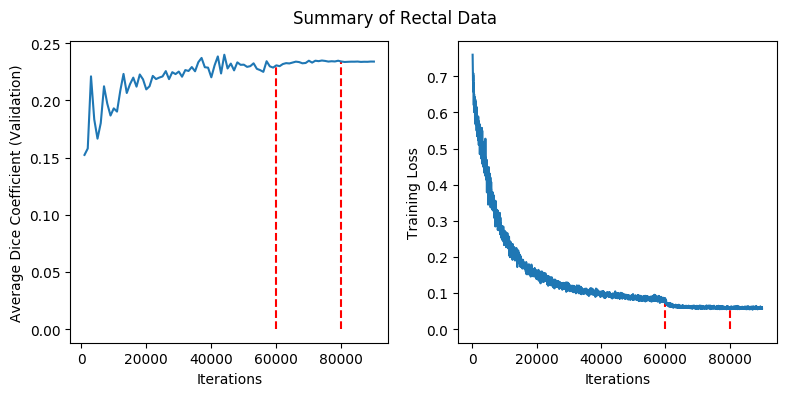

In [5]:
# Visualize the results during training
fig,axs=plt.subplots(1,2,dpi=100,figsize=(8,4))

plt.subplot(axs[0])
# Validation plot
idx1=np.where(checkpoints==int(6e4))[0][0]
idx2=np.where(checkpoints==int(8e4))[0][0]
plt.plot(checkpoints,dice_val)
plt.vlines(int(6e4),0,dice_val[idx1],colors='r',linestyles='dashed')
plt.vlines(int(8e4),0,dice_val[idx2],colors='r',linestyles='dashed')
plt.xlabel('Iterations')
plt.ylabel('Average Dice Coefficient (Validation)')

# Training Loss
plt.subplot(axs[1])
idx1=np.where(iterations==int(6e4))[0][0]
idx2=np.where(iterations==int(8e4))[0][0]
plt.plot(iterations[5:],losses[5:])
plt.vlines(int(6e4),0,losses[idx1],colors='r',linestyles='dashed')
plt.vlines(int(8e4),0,losses[idx2],colors='r',linestyles='dashed')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

plt.suptitle('Summary of Rectal Data')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Average Dice on Test Set

In [6]:
from pycocotools.coco import COCO
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from sklearn.metrics import f1_score,precision_score,recall_score
import torch

In [7]:
def dice(maskgt,maskdt):
    intersect=np.logical_and(maskdt,maskgt).sum()
    dice=2*intersect/(maskdt.sum()+maskgt.sum()+np.spacing(1))
    return dice

def recall(maskgt,maskdt):
    intersect=np.logical_and(maskdt,maskgt).sum()
    recall=intersect/(maskgt.sum()+np.spacing(1))
    return recall

def precision(maskgt,maskdt):
    intersect=np.logical_and(maskdt,maskgt).sum()
    precision=intersect/(maskdt.sum()+np.spacing(1))
    return precision

In [8]:
# load the ground truth
annFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/datasets/rectal/test.json'

coco=COCO(annFile)
imgIds=coco.getImgIds()
imgsInfo=coco.loadImgs(imgIds)
whs=[(img['width'],img['height']) for img in imgsInfo]
patients_dict=Counter([info['file_name'].split('/')[3][:6] for info in imgsInfo])
inds=np.cumsum(list(patients_dict.values()))-1

masksgt=[]
maskgtstk=[]
print('Loading the masks...')
for i,imgId in enumerate(imgIds):
    annIds=coco.getAnnIds(imgIds=imgId)
    anns=coco.loadAnns(annIds)
    maskgt=[]
    for ann in anns:
        if ann['segmentation']:
            maskgt.append(coco.annToMask(ann))
        else:
            maskgt.append(np.zeros(tuple(whs[i][::-1]),dtype=np.uint8))
    maskgtstk.append((np.sum(maskgt,0)>0).astype(np.uint8))
    if i in inds:
        maskgtstk=np.stack(maskgtstk,axis=0)
        masksgt.append(maskgtstk)
        maskgtstk=[]
print('Loading Complete!')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading the masks...
Loading Complete!


In [9]:
# load the prediction
predictFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/logs/rectal_benchmark_1_16/inference/coco_rectal_test/predictions.pth'
predictions=torch.load(predictFile)
threshold=0.5

masker=Masker(threshold)
print('Loading the predictions...')
masksdt=[]
maskdtstk=[]
for i,prediction in enumerate(predictions):
    prediction=prediction.resize(whs[i])
    if not len(prediction):
        # if num of box is 0, there is no mask (2019/01/16)
        maskdt=np.zeros(tuple(whs[i][::-1]),dtype=np.uint8)
    else:
        maskdt=prediction.get_field('mask')
        if list(maskdt.shape[-2:]) != list(whs[i][::-1]):
            maskdt = masker(maskdt.expand(1, -1, -1, -1, -1), prediction)
            maskdt = maskdt[0]
        maskdt=maskdt.numpy().sum((0,1))
    maskdtstk.append((maskdt>0).astype(np.uint8))
    if i in inds:
        maskdtstk=np.stack(maskdtstk,axis=0)
        masksdt.append(maskdtstk)
        maskdtstk=[]
print('Loading Complete!')

Loading the predictions...
Loading Complete!


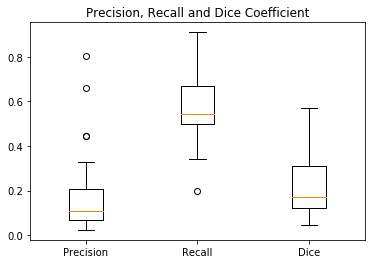

In [10]:
dice_rlts=[]
rc_rlts=[]
pr_rlts=[]
for maskgt,maskdt in zip(masksgt,masksdt):
    dice_rlts.append(dice(maskgt,maskdt))
    rc_rlts.append(recall(maskgt,maskdt))
    pr_rlts.append(precision(maskgt,maskdt))
dice_rlts=np.array(dice_rlts)
rc_rlts=np.array(rc_rlts)
pr_rlts=np.array(pr_rlts)
plt.boxplot([pr_rlts,rc_rlts,dice_rlts],labels=['Precision','Recall','Dice'])
plt.title('Precision, Recall and Dice Coefficient')
plt.show()

In [11]:
print('The average precision is :',np.mean(pr_rlts))
print('The average recall is :',np.mean(rc_rlts))
print('The average dice coefficient is :',np.mean(dice_rlts))

The average precision is : 0.18481980818366503
The average recall is : 0.5838221580320646
The average dice coefficient is : 0.23584576439441446


# Visualize the Test Results

## Ground Truth with Masks

In [12]:
maskdtct=np.concatenate(masksdt,0)
maskgtct=np.concatenate(masksgt,0)
inds_with_mask=np.array([i for i in range(maskgtct.shape[0]) if maskgtct[i].sum()>0])

In [13]:
from numpy.random import choice,seed
import cv2

In [14]:
dataFile='/home/r7user3/ZhangHT/github/maskrcnn-benchmark/datasets/rectal/'

In [15]:
polysdt=[]
polysgt=[]
for i in range(maskgtct.shape[0]):
    try:
        polysdt.append(cv2.findContours(maskdtct[i],cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[0])
    except: 
        polysdt.append(None)
    
    try:
        polysgt.append(cv2.findContours(maskgtct[i],cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[0])
    except:
        polysgt.append(None)

In [16]:
dice_rlts=[]
rc_rlts=[]
pr_rlts=[]
for maskgt,maskdt in zip(maskgtct,maskdtct):
    dice_rlts.append(dice(maskgt,maskdt))
    rc_rlts.append(recall(maskgt,maskdt))
    pr_rlts.append(precision(maskgt,maskdt))
dice_rlts=np.array(dice_rlts)
rc_rlts=np.array(rc_rlts)
pr_rlts=np.array(pr_rlts)

In [17]:
def show(imgs,inds,polysgt,polysdt,is_area=False,areas=None):
    fig,axs=plt.subplots(2,n,figsize=(n,2),dpi=250)
    color=[0,0.9,0.9]
    for i,ind in enumerate(inds):
        plt.subplot(axs[0,i])
        plt.imshow(imgs[i])
        for poly in polysgt[ind]:
            plt.gca().add_patch(plt.Polygon(poly.reshape(-1,2),color=color,linewidth=0)) 
        plt.xticks([])
        plt.yticks([])
        if not i:
            plt.ylabel('Ground Truth',fontsize=5)

        plt.subplot(axs[1,i])
        plt.imshow(imgs[i])
        for poly in polysdt[ind]:
            plt.gca().add_patch(plt.Polygon(poly.reshape(-1,2),color=color,linewidth=0)) 
        plt.xticks([])# hide the x,y axis but remain labels
        plt.yticks([])
        if not is_area:
            plt.xlabel('PR = %.4f\nRC = %.4f\nDice = %.4f'% \
                       (pr_rlts[ind],rc_rlts[ind],dice_rlts[ind]),fontsize=5)
        else:
            plt.xlabel('Area = %.1f'%areas[ind],fontsize=5)
        if not i:
            plt.ylabel('Prediction',fontsize=5)
    plt.show()

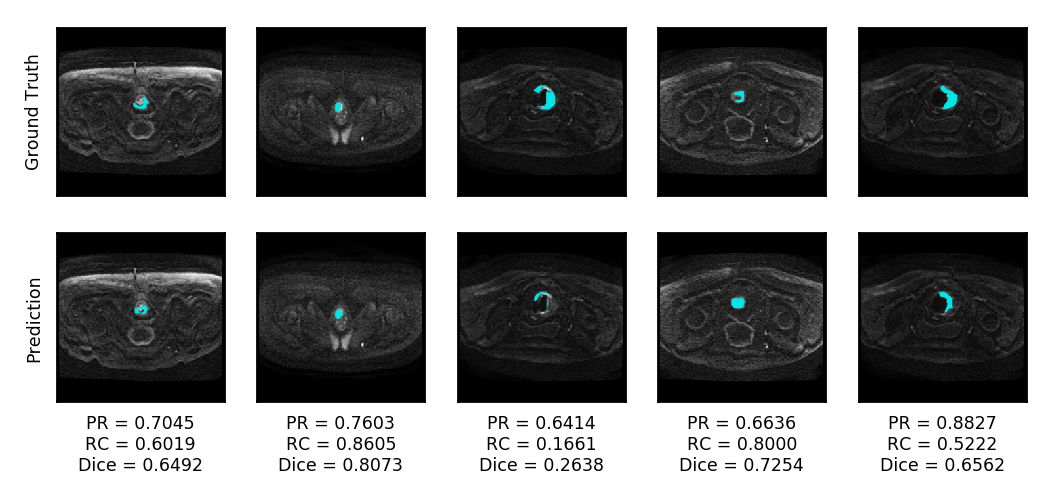

In [18]:
# show random
seed(2018)
n=5
inds=choice(inds_with_mask,n)
sub_imgsInfo=coco.loadImgs([imgIds[i] for i in inds])
imgs=[plt.imread(dataFile+i['file_name']) for i in sub_imgsInfo]
show(imgs,inds,polysgt,polysdt)

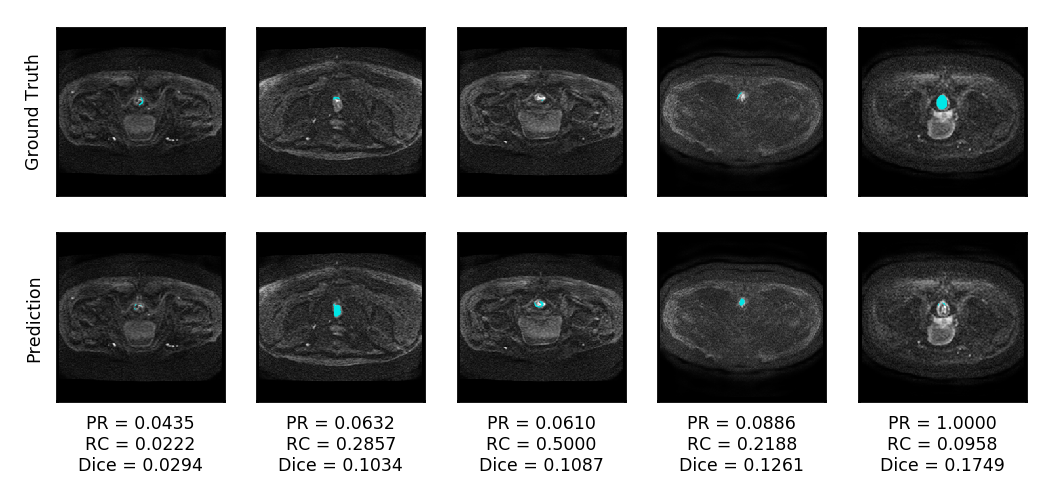

In [19]:
# show Dice (low->high)
sub_inds=np.argsort(dice_rlts[inds_with_mask])[:n].astype(np.int)
inds=inds_with_mask[sub_inds]
sub_imgsInfo=coco.loadImgs([imgIds[i] for i in inds])
imgs=[plt.imread(dataFile+i['file_name']) for i in sub_imgsInfo]
show(imgs,inds,polysgt,polysdt)

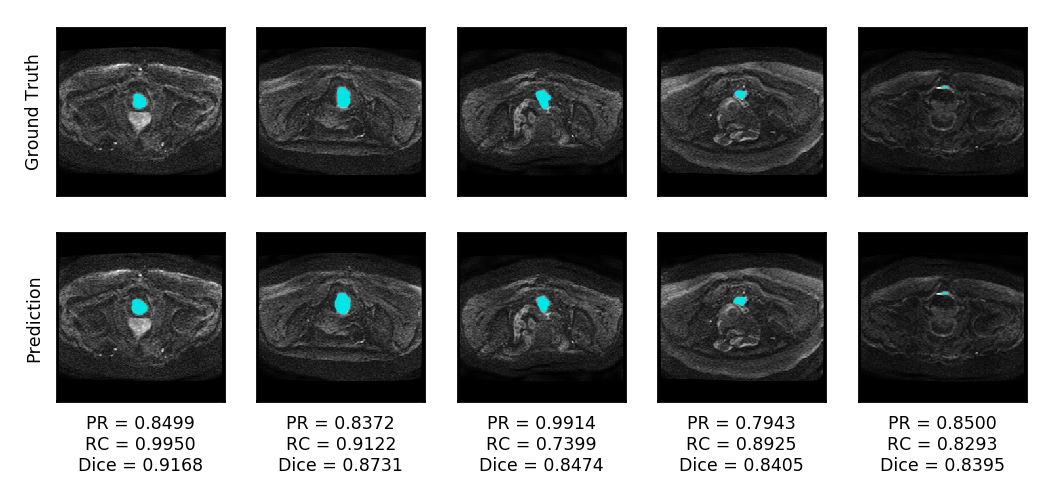

In [20]:
# show Dice (high->low)
sub_inds=np.argsort(-dice_rlts[inds_with_mask])[:n].astype(np.int)
inds=inds_with_mask[sub_inds]
sub_imgsInfo=coco.loadImgs([imgIds[i] for i in inds])
imgs=[plt.imread(dataFile+i['file_name']) for i in sub_imgsInfo]
show(imgs,inds,polysgt,polysdt)

## False Positive

In [21]:
inds_FP=np.array([i for i in range(maskgtct.shape[0]) if not maskgtct[i].sum() and maskdtct[i].sum()])

In [22]:
dt_areas=maskdtct.sum((1,2))

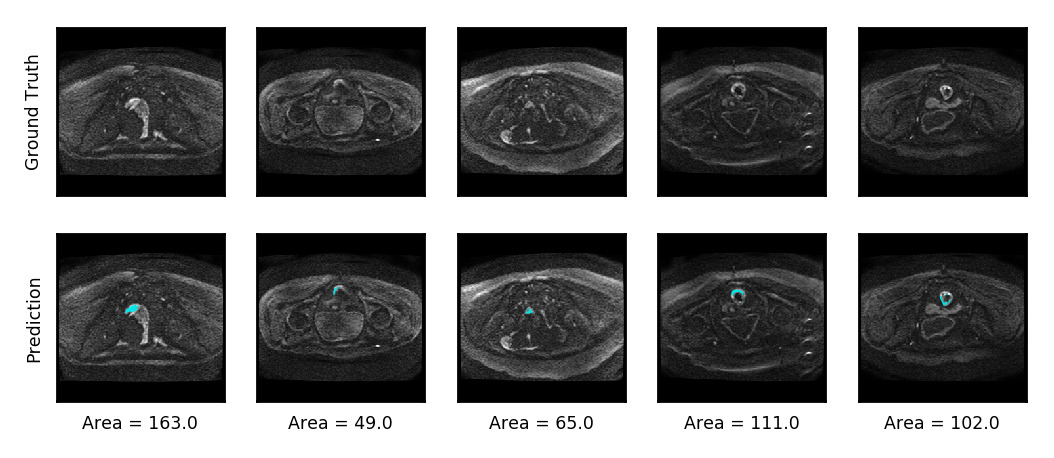

In [23]:
# show random
seed(2018)
n=5
inds=choice(inds_FP,n)
sub_imgsInfo=coco.loadImgs([imgIds[i] for i in inds])
imgs=[plt.imread(dataFile+i['file_name']) for i in sub_imgsInfo]
show(imgs,inds,polysgt,polysdt,True,dt_areas)

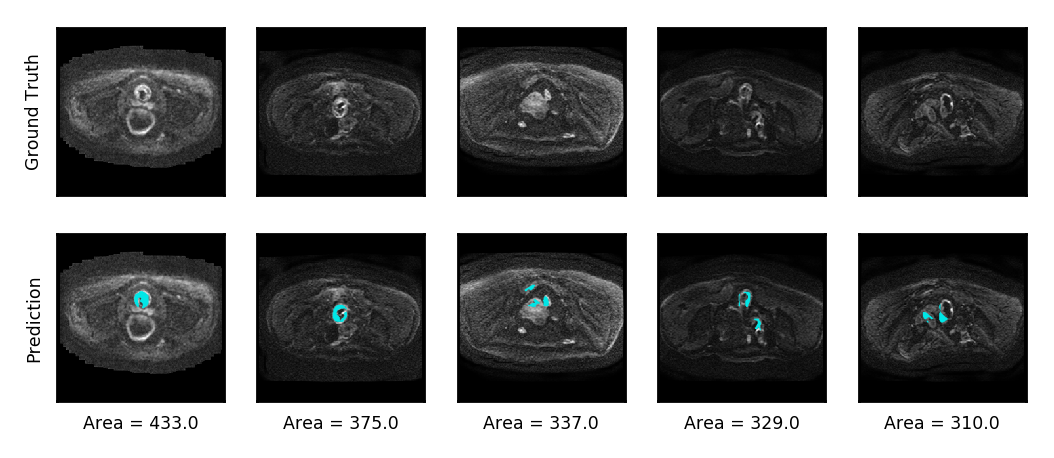

In [24]:
# show area (high->low)
sub_inds=np.argsort(-dt_areas[inds_FP])[:n].astype(np.int)
inds=inds_FP[sub_inds]
sub_imgsInfo=coco.loadImgs([imgIds[i] for i in inds])
imgs=[plt.imread(dataFile+i['file_name']) for i in sub_imgsInfo]
show(imgs,inds,polysgt,polysdt,True,dt_areas)

## False Negative

In [25]:
inds_FN=np.array([i for i in range(maskgtct.shape[0]) if maskgtct[i].sum() and not maskdtct[i].sum()])

In [26]:
len(inds_FN)

0